# Historical Wildfire Analysis


Spatial wildfire occurrence data, referred to as the **Fire Program Analysis fire-occurrence database (FPA FOD)**, for the United States, 1992-2015 was obtained from https://www.fs.usda.gov/rds/archive/Product/RDS-2013-0009.4/. The dataset contains data on:
* 1.88 Million US Wildfires
* 24 years of geo-referenced wildfire records

<img src="wildfires.png" width="600" />

### Given this data, can we answer the following questions?
* **Are wildfires increasing over time?**
* **Where are the fire hot spots?**
* **Can Machine Learning categorize the cause of the fire given the size, location and date?**

That would give investigators a data driven way to prioritize cases for further investigation.

In [1]:
from arcgis import *
import pandas as pd
import numpy as np

In [2]:
gis = GIS(profile='deldev.maps')

In [9]:
from arcgis.features import SpatialDataFrame

wildfires_df = SpatialDataFrame.from_featureclass(r'C:\demo\FPA_FOD_20170508.gdb\Fires')

In [10]:
wildfires_df.shape

(1880465, 39)

In [11]:
df = wildfires_df[['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'STATE', 'FIPS_CODE', 'FIPS_NAME', 'SHAPE']]

In [12]:
df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,FIPS_NAME,SHAPE
0,2005,2005-02-02,33,Miscellaneous,0.10,CA,063,Plumas,"{'x': -121.00583333000003, 'y': 40.03694443999..."
1,2004,2004-05-12,133,Lightning,0.25,CA,061,Placer,"{'x': -120.40444444000002, 'y': 38.93305556000..."
2,2004,2004-05-31,152,Debris Burning,0.10,CA,017,El Dorado,"{'x': -120.73555555999997, 'y': 38.98416666999..."
3,2004,2004-06-28,180,Lightning,0.10,CA,003,Alpine,"{'x': -119.91333333, 'y': 38.55916666999997, '..."
4,2004,2004-06-28,180,Lightning,0.10,CA,003,Alpine,"{'x': -119.93305555999996, 'y': 38.55916666999..."


### Exploratory Data Analysis

In [158]:
df['x'] = df.SHAPE.apply(lambda g: g['x'])
df['y'] = df.SHAPE.apply(lambda g: g['y'])
smdf = wildfires_df[['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'STATE', 'FIPS_CODE', 'FIPS_NAME', 'x', 'y']]
smdf.to_pickle('fires.pkl')

In [135]:
pd.options.mode.chained_assignment = None 

df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.dayofweek
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
dfa = df_arson['DAY_OF_WEEK'].value_counts()
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
dfl = df_lightning['DAY_OF_WEEK'].value_counts()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sorted_df = df.sort_values('FIRE_YEAR')
fire_freq = sorted_df.groupby('FIRE_YEAR').count()
x = np.asarray(fire_freq.axes[0])
y = np.asarray(df.groupby('FIRE_YEAR').size())

In [247]:
lyr = gis.content.search('Demographic Profile')[0]
lyr

<Item title:"Demographic Profile" type:Feature Layer Collection owner:deldev>

### Have wildfires become more frequent over time?

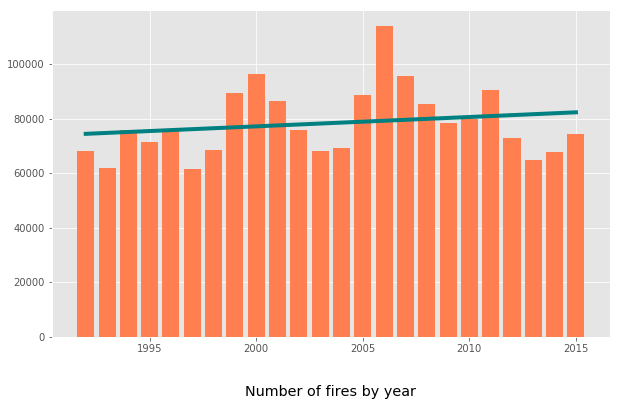

In [148]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, y, color='coral')
plt.title('Number of fires by year', y=-0.2)
fit1 = np.polyfit(x, y, deg=1)
ax.plot(x, x*fit1[0] + fit1[1], color='teal', linewidth=4);

### What are the causes of wildfire?

In [55]:
distribution = df['STAT_CAUSE_DESCR'].value_counts()

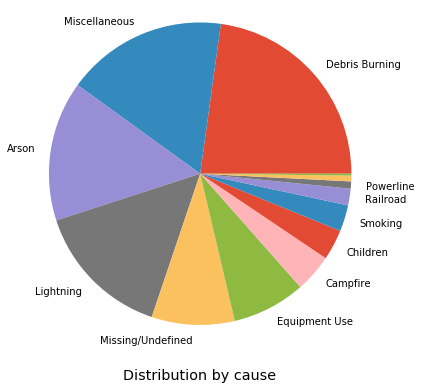

In [143]:
plt.figure(figsize=(6,6))
plt.title('Distribution by cause', y=-0.15)
plt.pie(distribution, labels=list(distribution.index[:-2]) + ['', '']);
plt.axis('equal');

### Does the day of week matter?

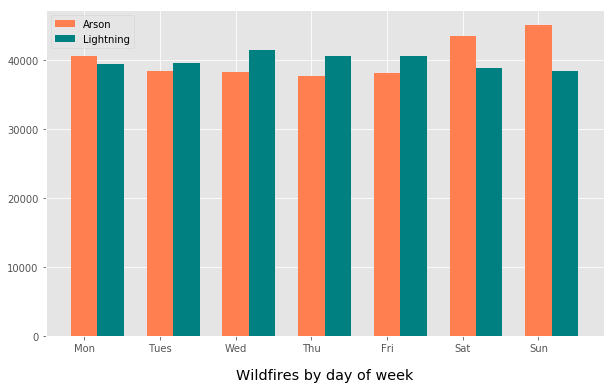

In [152]:
ind = np.arange(7) 
width = 0.35       

fig, ax   = plt.subplots(figsize=(10,6))
arson     = ax.bar(ind, dfa.sort_index(), width, color='coral')
lightning = ax.bar(ind + width, dfl.sort_index(), width, color='teal')

ax.set_title('Wildfires by day of week', y=-0.15)
ax.set_xticklabels(('', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
ax.legend((arson[0], lightning[0]), ('Arson', 'Lightning'), loc=2);

## Mapping and Spatial Analysis

In [ ]:
wildfires = gis.content.import_data(wildfires_df)

In [ ]:
from arcgis.features.analysis import find_hot_spots
hotspots = find_hot_spots(wildfires, 20, 'Miles', output_name='Hot Spots US_Historical_Wildfires_20')

In [153]:
hotspots = gis.content.get('8f9e60e114c749a9864e4adb9643d096')

In [154]:
usmap = gis.map('United States')
usmap.add_layer(hotspots)
usmap

### Mapping using Python plotting libraries

In [97]:
import pandas as pd
import numpy as np
import colorcet as cc
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LogColorMapper

In [101]:
from bokeh.io import hplot

In [90]:
pd.options.mode.chained_assignment = None

In [91]:
viz_df = wildfires_df[['LATITUDE', 'LONGITUDE','FIRE_SIZE', 'STATE']]

In [92]:
new = viz_df.loc[(viz_df.loc[:,'STATE']!='AK') & (viz_df.loc[:,'STATE']!='HI') & (viz_df.loc[:,'STATE']!='PR')]

In [93]:
new.loc[:,'LATITUDE'] = ((new.loc[:,'LATITUDE']*10).apply(np.floor))/10
new.loc[:,'LONGITUDE'] = ((new.loc[:,'LONGITUDE']*10).apply(np.floor))/10
new.loc[:,'LL_COMBO'] = new.loc[:,'LATITUDE'].map(str) + '-' + new.loc[:,'LONGITUDE'].map(str)
grouped = new.groupby(['LL_COMBO', 'LATITUDE', 'LONGITUDE'])
number_of_wf = grouped['FIRE_SIZE'].agg(['count']).reset_index()
size_of_wf = grouped['FIRE_SIZE'].agg(['mean']).reset_index()
source = ColumnDataSource(number_of_wf)
p1 = figure(title="Number of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means more wildfires)",
           toolbar_location=None, plot_width=750, plot_height=450)
p1.background_fill_color = "black"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LogColorMapper(palette=cc.fire)
glyph = p1.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
output_notebook()

In [142]:
show(p1)

Loading BokehJS ...

## Can Machine Learning categorize the cause of the fire?

Since **arson** is a significant preventable cause for many wildfires, it would be instructive to see if Machine Learning techniques can be used to classify if a fire was caused due to arson given some basic data that is available when the fire is first discovered or when investigations begin. This can be framed as a **binary classification** problem.

Such a technique could give investigators a data driven way to prioritize cases for further investigation.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True

In [162]:
df = pd.read_pickle('fires.pkl')

df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.dayofweek

ca_fires = df[df.STATE=='CA']
ca_fires['ARSON'] = ca_fires['STAT_CAUSE_DESCR'].apply(lambda x: 1 if x == 'Arson' else 0) 

pdf = ca_fires[ ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIPS_CODE', 'FIRE_SIZE', 'x', 'y', 'MONTH', 'DAY_OF_WEEK', 'ARSON'] ]
pdf = pdf.dropna()

### Feature Engineering: Use geoenrichment to add features

In [206]:
analysis_variables = [
    'TOTPOP_CY',  # 2016 Population: Total Population (Esri)
    'HHPOP_CY',   # 2016 Household Population (Esri)
    'FAMPOP_CY',  # 2016 Family Population (Esri)
    'DIVINDX_CY', # 2016 Diversity Index (Esri)
    'TOTHH_CY',   # 2016 Total Households (Esri)
    'AVGHHSZ_CY', # 2016 Average Household Size (Esri)

    'MALES_CY',   # 2016 Gender: Male Population (Esri)
    'FEMALES_CY', # 2016 Gender: Female Population (Esri)
    
    'MEDAGE_CY',  # 2016 Age: Median Age (Esri)
    
    'AVGFMSZ_CY', # 2016 Income: Average Family Size (Esri)
    'MEDHINC_CY', # 2016 Income: Median Household Income (Esri)
    'AVGHINC_CY', # 2016 Income: Average Household Income (Esri)
        
    'EDUCBASECY', # 2016 Educational Attainment Base (Esri)
    'NOHS_CY',    # 2016 Education: Less than 9th Grade (Esri)
    'SOMEHS_CY',  # 2016 Education: 9-12th Grade/No Diploma (Esri)
    'HSGRAD_CY',  # 2016 Education: High School Diploma (Esri)
    'GED_CY',     # 2016 Education: GED/Alternative Credential (Esri)
    'SMCOLL_CY',  # 2016 Education: Some College/No Degree (Esri)
    'ASSCDEG_CY', # 2016 Education: Associate's Degree (Esri)
    'BACHDEG_CY', # 2016 Education: Bachelor's Degree (Esri)
]

In [239]:
from arcgis.geoenrichment import *

usa = Country.get('US')
counties = usa.subgeographies.states['California'].counties

enrich_df = enrich(list(counties.values()), analysis_variables=analysis_variables)

pdf['StdGeographyID'] = '06' + pdf['FIPS_CODE']
merged = pd.merge(pdf, enrich_df, on='StdGeographyID')
cols = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIPS_CODE', 'FIRE_SIZE', 'x', 'y', 'MONTH', 'DAY_OF_WEEK', 'ARSON'] + analysis_variables
mdf = merged[cols]

mdf.head()

,FIRE_YEAR,DISCOVERY_DOY,FIPS_CODE,FIRE_SIZE,x,y,MONTH,DAY_OF_WEEK,ARSON,TOTPOP_CY,...,MEDHINC_CY,AVGHINC_CY,EDUCBASECY,NOHS_CY,SOMEHS_CY,HSGRAD_CY,GED_CY,SMCOLL_CY,ASSCDEG_CY,BACHDEG_CY
0,2005,33,063,0.1,-121.005833,40.036944,2,2,0,19292,...,45275,66596,14802,447,909,3153,415,4803,1672,2048
1,2005,153,063,2.3,-120.451111,39.817222,6,3,0,19292,...,45275,66596,14802,447,909,3153,415,4803,1672,2048
2,2005,234,063,0.5,-121.147500,39.872222,8,0,0,19292,...,45275,66596,14802,447,909,3153,415,4803,1672,2048
3,2005,241,063,0.1,-120.903889,39.962222,8,0,0,19292,...,45275,66596,14802,447,909,3153,415,4803,1672,2048
4,2005,242,063,1.0,-120.706667,40.056944,8,1,0,19292,...,45275,66596,14802,447,909,3153,415,4803,1672,2048


In [241]:
m = gis.map('California')
m 

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [245]:
lyr = gis.content.import_data(enrich_df, title='Demographic Profile')

In [248]:
m.add_layer(lyr, {'renderer':'ClassedColorRenderer', 'field':'AVGHINC_CY'})

### Fit Random Forest classifier and check accuracy

In [240]:
X = mdf.drop(['ARSON'], axis=1).values
y = mdf['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)

print(clf_rf.score(X_test, y_test))

0.9212070907689571


Summary: Given some basic data, available when a fire is first discovered, it is possible to predict with over 90% accuracy if the fire was the result of arson.


**Citations**

Short, Karen C. 2017. Spatial wildfire occurrence data for the United States, 1992-2015 [FPA_FOD_20170508]. 4th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.4

Paul O'Neill. 2017. Predict the causes of wildfires using Python. https://www.kaggle.com/edhirif/predict-the-causes-of-wildfires-using-python

Jan Oliehoek. 2017. Wildfire visualization: heat maps (literally). https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally